In [332]:
from nltk.tokenize import word_tokenize
import pymorphy2
import nltk
from nltk.corpus import stopwords
from string import punctuation
import json
import pandas as pd
import re
import codecs
import functools
from gensim.models import CoherenceModel
import string
import numpy as np
import matplotlib
from gensim.models import LsiModel
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel
nltk.download('punkt')
nltk.download("stopwords")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\glebn\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\glebn\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [252]:
import warnings
warnings.filterwarnings('ignore')

In [200]:
f1 = codecs.open("C:/Users/glebn/Desktop/72_news(2).json", "r", "utf_8_sig")
f2 = codecs.open("C:/Users/glebn/Desktop/nn_news.json", "r", "utf_8_sig")
f3 = codecs.open("C:/Users/glebn/Desktop/corpus.json", "r", "utf_8_sig")
data1 = json.load(f1)
data2 = json.load(f2)
data3 = json.load(f3)
data1 =pd.DataFrame(data1['catalogue'])
data2 =pd.DataFrame(data2['catalogue'])
data3 =pd.DataFrame(data3['catalogue'])

In [203]:
data2['category'].replace('culture','Культура',inplace=True)
data2['category'].replace('transport','Транспорт',inplace=True)
data2['category'].replace('gorod','Город',inplace=True)
data2['category'].replace('economics','Экономика',inplace=True)

In [204]:
data1['category'].replace('entertainment','Развлечения',inplace=True)
data1['category'].replace('health','Здоровье',inplace=True)
data1['category'].replace('auto','Авто',inplace=True)
data1['category'].replace('economics','Экономика',inplace=True)

In [205]:
for i in range(len(data3['tags'])):
    data3['tags'][i] = ','.join(str(e) for e in data3['tags'][i])

In [206]:
data3.rename(columns={"link": "article_id"},inplace=True)

In [207]:
dfs=pd.concat([data1, data2],ignore_index = True,sort = False)
dfs=pd.concat([dfs, data3],ignore_index = True,sort = False)

In [208]:
num_of_categories = len(dfs['category'].unique())

In [209]:
initial_texts_list = dfs['text'].tolist()

**Preprocessing**

In [210]:
translator = str.maketrans('', '', string.punctuation)

def lower_case(text):
    return text.lower()

def remove_numbers(text):
    return re.sub(r'\d+', '', text)

def remove_whitespaces(text):
    return " ".join(text.split())

def remove_punctuation(text):
    text = re.sub(r'[^\w\s]', '', text)
    return text.translate(translator)

def preprocess_first_stage(text):
    text = lower_case(text)
    text = remove_numbers(text)
    text = remove_whitespaces(text)
    text = remove_punctuation(text)
    return text

In [211]:
for i in range(len(dfs)):
    dfs['title'][i] = preprocess_first_stage(dfs['title'][i])
    dfs['text'][i] = preprocess_first_stage(dfs['text'][i])

In [212]:
russian_stopwords = stopwords.words("russian")
english_stopwords = stopwords.words("english")
morph = pymorphy2.MorphAnalyzer()
russian_stopwords.append('всё')
russian_stopwords.append('это')
russian_stopwords.append('ещё')
def preprocess_text(text):
  preprocessed = []
  tokenized = word_tokenize(text)
  for word in tokenized:
     p = morph.parse(word)[0]
     normalized = p.normal_form
     if normalized not in russian_stopwords and normalized not in punctuation and normalized not in english_stopwords:
       preprocessed.append(normalized)
  return preprocessed

In [213]:
for i in range(len(dfs)):
    if (i % 1000 == 0):
        print(i)
    dfs['category'][i] = preprocess_text(dfs['category'][i])
    dfs['title'][i] = preprocess_text(dfs['title'][i])
    dfs['text'][i] = preprocess_text(dfs['text'][i])

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000


***Word Cloud***

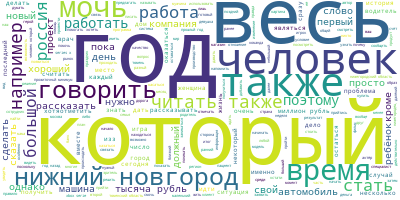

In [214]:
from wordcloud import WordCloud
long_string = ','.join(np.concatenate(list(dfs['text'].values)))
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
wordcloud.generate(long_string)
wordcloud.to_image()

>Слова весь, который, год мы убрали из текстов

In [215]:
unwanted_words = ['весь', 'который', 'год', 'мочь', 'читать также', 'nnru', 'также']
def remove_unwanted_words(text):
    preprocessed = []
    for word in text:
        if word not in unwanted_words and len(word)>1:
            if(word == 'н'):
                print(word)
            preprocessed.append(word)
    return preprocessed

In [216]:
for i in range(len(dfs)):
    if (i % 1000 == 0):
        print(i)
    dfs['text'][i] = remove_unwanted_words(dfs['text'][i])

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000


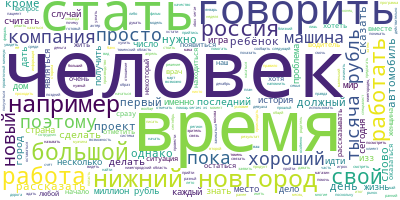

In [217]:
from wordcloud import WordCloud
long_string = ','.join(np.concatenate(list(dfs['text'].values)))
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
wordcloud.generate(long_string)
wordcloud.to_image()

**Corpus creation**

In [218]:
texts_list = dfs['text'].tolist()

In [219]:
common_dictionary = Dictionary(texts_list)
common_corpus = [common_dictionary.doc2bow(text) for text in texts_list]                            

**LDA Model**

In [244]:
num_of_categories_t = [4, 8, 12, 16]
chunksize_t = [1000, 2000]
passes_t = [5, 1]
minimum_probability_t = [0.01, 0.05]
eval_every_t = [10]
iterations_t = [20]
eta_t = [None, 'symmetric']
gamma_threshold_t = [0.001, 0.00001]
alpha_t = ['symmetric', 'asymmetric']

best_parameters_lda = {num_of_categories_: [] for num_of_categories_ in num_of_categories_t}
best_coherence_lda = {num_of_categories_: -100 for num_of_categories_ in num_of_categories_t}
perplexity = {num_of_categories_: -100 for num_of_categories_ in num_of_categories_t}

for num_of_categories_ in num_of_categories_t:
    print("num_of_topics = " + str(num_of_categories_))
    best_lda_model = LdaModel(common_corpus, num_topics=num_of_categories_, id2word=common_dictionary, chunksize=chunksize_t[0],
                              passes=passes_t[0], eval_every=eval_every_t[0], iterations=iterations_t[0], gamma_threshold=gamma_threshold_t[0],
                              alpha = alpha_t[0], eta=eta_t[0], minimum_probability=minimum_probability_t[0])
    print(np.exp2(-1*best_lda_model.log_perplexity(common_corpus)))
    perplexity[num_of_categories_] = np.exp2(-1*best_lda_model.log_perplexity(common_corpus))
    coherence_model_lda = CoherenceModel(model=best_lda_model, corpus=common_corpus, dictionary=common_dictionary, coherence='u_mass')
    max_coherence = coherence_model_lda.get_coherence()
    best_parameters_lda[num_of_categories_] = [chunksize_t[0], passes_t[0], gamma_threshold_t[0], alpha_t[0], eval_every_t[0], eta_t[0], minimum_probability_t[0], iterations_t[0]]
    for chunksize_ in chunksize_t:
        for passes_ in passes_t:
            for alpha_ in alpha_t:
                for gamma_threshold_ in gamma_threshold_t:
                    for eval_every_ in eval_every_t:
                        for eta_ in eta_t:
                            for minimum_probability_ in minimum_probability_t:
                                for iterations_ in iterations_t:
                                    print("chunksize = " + str(chunksize_) + " passes = " + str(passes_) + " gamma_threshold = " + str(gamma_threshold_) +
                                        " alpha = " + alpha_ + " eval_every = " + str(eval_every_) + " iterations = " + str(iterations_), " eta = " + str(eta_) + " minimum probability = " + str(minimum_probability_))
                                    model_lda = LdaModel(common_corpus, num_topics=num_of_categories_,id2word=common_dictionary,
                                                        chunksize=chunksize_, passes=passes_, gamma_threshold=gamma_threshold_, alpha=alpha_, eval_every=eval_every_, iterations=iterations_, eta=eta_,
                                                        minimum_probability=minimum_probability_)
                                    coherence_model_lda = CoherenceModel(model=model_lda, corpus=common_corpus, dictionary=common_dictionary, coherence='u_mass')
                                    if (coherence_model_lda.get_coherence() > max_coherence):
                                        best_lda_model = model_lda
                                        max_coherence = coherence_model_lda.get_coherence()
                                        best_parameters_lda[num_of_categories_] = [chunksize_, passes_, gamma_threshold_, alpha_, eval_every_, eta_, minimum_probability_, iterations_]
    best_coherence_lda[num_of_categories_] = max_coherence
    perplexity[num_of_categories_] = np.exp2(-1*best_lda_model.log_perplexity(common_corpus))
                         



num_of_topics = 4
442.77807336871837
chunksize = 1000 passes = 5 gamma_threshold = 0.001 alpha = symmetric eval_every = 10 iterations = 20  eta = None minimum probability = 0.01
chunksize = 1000 passes = 5 gamma_threshold = 0.001 alpha = symmetric eval_every = 10 iterations = 20  eta = None minimum probability = 0.05
chunksize = 1000 passes = 5 gamma_threshold = 0.001 alpha = symmetric eval_every = 10 iterations = 20  eta = symmetric minimum probability = 0.01
chunksize = 1000 passes = 5 gamma_threshold = 0.001 alpha = symmetric eval_every = 10 iterations = 20  eta = symmetric minimum probability = 0.05
chunksize = 1000 passes = 5 gamma_threshold = 1e-05 alpha = symmetric eval_every = 10 iterations = 20  eta = None minimum probability = 0.01
chunksize = 1000 passes = 5 gamma_threshold = 1e-05 alpha = symmetric eval_every = 10 iterations = 20  eta = None minimum probability = 0.05
chunksize = 1000 passes = 5 gamma_threshold = 1e-05 alpha = symmetric eval_every = 10 iterations = 20  eta 

Coherence, top models parameters

In [247]:
print(best_coherence_lda)
print(best_parameters_lda)

{4: -1.2067288160986367, 8: -1.281923963422434, 12: -1.45138594281601, 16: -1.4680344164724222}
{4: [2000, 1, 1e-05, 'symmetric', 10, None, 0.01, 20], 8: [2000, 5, 1e-05, 'symmetric', 10, 'symmetric', 0.05, 20], 12: [2000, 1, 1e-05, 'asymmetric', 10, None, 0.01, 20], 16: [2000, 1, 1e-05, 'asymmetric', 10, 'symmetric', 0.01, 20]}


Text(0.5, 1.0, 'Coherence for top models (4/8/12/16 topics)')

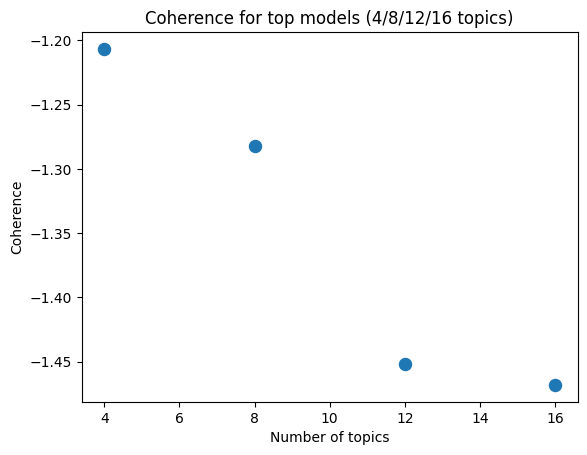

In [330]:
matplotlib.pyplot.scatter(list(best_coherence_lda.keys()),list(best_coherence_lda.values()), marker='.', s=300)
matplotlib.pyplot.xlabel("Number of topics")
matplotlib.pyplot.ylabel("Coherence")
matplotlib.pyplot.title("Coherence for top models (4/8/12/16 topics)")

In [261]:
parameters_4 = best_parameters_lda[4]
parameters_8 = best_parameters_lda[8]
parameters_12 = best_parameters_lda[4]
parameters_16 = best_parameters_lda[8]

model_lda_4 = LdaModel(common_corpus, num_topics=4,id2word=common_dictionary,
                                                        chunksize=parameters_4[0], passes=parameters_4[1], gamma_threshold=parameters_4[2], alpha=parameters_4[3], eval_every=parameters_4[4], 
                                                        eta=parameters_4[5], minimum_probability=parameters_4[6],iterations=parameters_4[7])
model_lda_8 = LdaModel(common_corpus, num_topics=8,id2word=common_dictionary,
                                                        chunksize=parameters_8[0], passes=parameters_8[1], gamma_threshold=parameters_8[2], alpha=parameters_8[3], eval_every=parameters_8[4], 
                                                        eta=parameters_8[5], minimum_probability=parameters_8[6],iterations=parameters_8[7])
model_lda_12 = LdaModel(common_corpus, num_topics=12,id2word=common_dictionary,
                                                        chunksize=parameters_12[0], passes=parameters_12[1], gamma_threshold=parameters_12[2], alpha=parameters_12[3], eval_every=parameters_12[4], 
                                                        eta=parameters_12[5], minimum_probability=parameters_12[6],iterations=parameters_12[7])
model_lda_16 = LdaModel(common_corpus, num_topics=16,id2word=common_dictionary,
                                                        chunksize=parameters_16[0], passes=parameters_16[1], gamma_threshold=parameters_16[2], alpha=parameters_16[3], eval_every=parameters_16[4], 
                                                        eta=parameters_16[5], minimum_probability=parameters_16[6],iterations=parameters_16[7])

LDAvis for top model (4 topics)

In [262]:
vis_4 = gensimvis.prepare(model_lda_4, common_corpus, common_dictionary)
pyLDAvis.enable_notebook() 
vis_4

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.104380 -0.048339       1        1  41.743101
0     -0.086428  0.048331       2        1  25.775148
3      0.178744 -0.005211       3        1  19.340255
1      0.012065  0.005219       4        1  13.141497, topic_info=           Term          Freq         Total Category  logprob  loglift
576        игра  11686.000000  11686.000000  Default  30.0000  30.0000
1235     читать  10312.000000  10312.000000  Default  29.0000  29.0000
17998      xbox   5916.000000   5916.000000  Default  28.0000  28.0000
10238   трейлер   4485.000000   4485.000000  Default  27.0000  27.0000
594       новый  14362.000000  14362.000000  Default  26.0000  26.0000
...         ...           ...           ...      ...      ...      ...
1111     россия   1012.681220  10819.665836   Topic4  -6.0491  -0.3394
1084   работать    897.393813   5430.623001   Topic4  -6.1699   0.2291
613       рубль   1086.495295  21046.981871   Topic4  -5.9787  -0.9344
536     человек    992.862628  11587.593424   Topic4  -6.0688  -0.4277
2695     доллар    881.751737   5534.078001   Topic4  -6.1875   0.1926

[372 rows x 6 columns], token_table=       Topic      Freq         Term
term                               
72695      1  0.036530   activision
72695      2  0.041401   activision
72695      3  0.056013   activision
72695      4  0.866983   activision
29061      1  0.031358      airpods
...      ...       ...          ...
50754      1  0.960103    экспортёр
50754      2  0.029316    экспортёр
50754      4  0.007329    экспортёр
71152      1  0.027089  электроникс
71152      2  0.975212  электроникс

[1166 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 4, 2])

>Выявлены темы похожие на Экономика (1), Город (2), Компьютерные игры + Кино (3)

LDAvis for top model (8 topics)

In [263]:
vis_8 = gensimvis.prepare(model_lda_8, common_corpus, common_dictionary)
pyLDAvis.enable_notebook() 
vis_8

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.088543  0.089401       1        1  23.043035
1     -0.116300 -0.034835       2        1  19.854861
2      0.034384  0.136319       3        1  14.848779
3      0.135707  0.202637       4        1  10.712643
6     -0.093600 -0.039799       5        1   9.997890
4      0.321257 -0.140635       6        1   8.963830
5     -0.140681 -0.022659       7        1   8.246440
7     -0.052225 -0.190429       8        1   4.332522, topic_info=           Term          Freq         Total Category  logprob  loglift
576        игра   6467.000000   6467.000000  Default  30.0000  30.0000
3540       цена   7906.000000   7906.000000  Default  29.0000  29.0000
613       рубль  15569.000000  15569.000000  Default  28.0000  28.0000
965      нижний   7151.000000   7151.000000  Default  27.0000  27.0000
14807  новгород   6468.000000   6468.000000  Default  26.0000  26.0000
...         ...           ...           ...      ...      ...      ...
2928     помощь    433.443462   2693.366378   Topic8  -5.7880   1.3122
161    компания    494.946600   7306.427489   Topic8  -5.6553   0.4470
381      работа    472.870197   7969.451516   Topic8  -5.7010   0.3145
1084   работать    448.887344   6188.292758   Topic8  -5.7530   0.5154
594       новый    435.839287  12462.614233   Topic8  -5.7825  -0.2142

[644 rows x 6 columns], token_table=       Topic      Freq        Term
term                              
70947      6  0.002514         amd
70947      8  0.993080         amd
14433      6  0.047860       apple
14433      8  0.950198       apple
74727      6  0.996007      ascent
...      ...       ...         ...
552        8  0.011640     эксперт
7481       3  0.990201  экспозиция
7481       4  0.006001  экспозиция
1661       3  0.982956     ярмарка
1661       5  0.014315     ярмарка

[2023 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 7, 5, 6, 8])

>Темы (5) и (7) оказались очень близки к теме (2). Они похожи на Экономика и Общество.

>(8) - Технологии, (3) - Город, (4) - Кино, (6) - Компьютерные игры

LDAvis for top model (12 topics)

In [265]:
vis_12 = gensimvis.prepare(model_lda_12, common_corpus, common_dictionary)
pyLDAvis.enable_notebook()
vis_12

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8      0.050567  0.059655       1        1  21.414802
10    -0.072051 -0.068127       2        1  13.980149
0     -0.089265 -0.038856       3        1  10.869758
6      0.249871 -0.003885       4        1  10.394872
9     -0.007145  0.042639       5        1  10.389879
5      0.013065 -0.122958       6        1   8.646701
1     -0.118849 -0.005265       7        1   6.975583
2     -0.030738  0.108340       8        1   6.706016
7     -0.064684  0.027194       9        1   3.679031
4      0.055403 -0.078738      10        1   3.580238
11     0.049361  0.037185      11        1   2.340458
3     -0.035534  0.042817      12        1   1.022514, topic_info=          Term          Freq         Total Category  logprob  loglift
576       игра  11577.000000  11577.000000  Default  30.0000  30.0000
1235    читать  11352.000000  11352.000000  Default  29.0000  29.0000
17998     xbox   5645.000000   5645.000000  Default  28.0000  28.0000
404    ребёнок   8272.000000   8272.000000  Default  27.0000  27.0000
613      рубль  14809.000000  14809.000000  Default  26.0000  26.0000
...        ...           ...           ...      ...      ...      ...
3540      цена     58.072126   7375.653201  Topic12  -6.3542  -0.2613
381     работа     56.636720   7492.392625  Topic12  -6.3792  -0.3021
89        день     55.893546   8010.840769  Topic12  -6.3925  -0.3822
443     случай     49.126831   4074.263890  Topic12  -6.5215   0.1649
1192    тысяча     50.066369   6775.008474  Topic12  -6.5026  -0.3247

[943 rows x 6 columns], token_table=       Topic      Freq    Term
term                          
17144      1  0.053065  adidas
17144      2  0.053065  adidas
17144      3  0.477582  adidas
17144      5  0.053065  adidas
17144      6  0.053065  adidas
...      ...       ...     ...
1250       8  0.024958  январь
1250       9  0.017576  январь
1250      10  0.022498  январь
1250      11  0.019685  январь
1250      12  0.004921  январь

[6418 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 11, 1, 7, 10, 6, 2, 3, 8, 5, 12, 4])

>Появились "небольшие" темы, которые сложно соотнести с исходными

LDAvis for top model (16 topics)

In [266]:
vis_16 = gensimvis.prepare(model_lda_16, common_corpus, common_dictionary)
pyLDAvis.enable_notebook()
vis_16

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.160553 -0.101469       1        1  14.194263
10    -0.102869  0.000329       2        1  13.127724
8     -0.096221  0.098845       3        1  12.335446
4     -0.070106  0.234566       4        1   9.131019
9     -0.099198  0.146120       5        1   8.346119
2     -0.089571 -0.083488       6        1   8.136194
14    -0.122259 -0.094914       7        1   7.380832
11    -0.027753 -0.098042       8        1   6.922166
3     -0.114068 -0.101498       9        1   5.974787
13    -0.092813 -0.001154      10        1   4.570319
5      0.006231 -0.037297      11        1   4.155064
6      0.039884 -0.084602      12        1   2.366127
0      0.096978  0.268304      13        1   1.927058
1      0.203161 -0.118943      14        1   0.791927
15     0.289731 -0.030955      15        1   0.483179
12     0.339427  0.004199      16        1   0.157774, topic_info=             Term          Freq         Total Category  logprob  loglift
576          игра   8538.000000   8538.000000  Default  30.0000  30.0000
3540         цена   6915.000000   6915.000000  Default  29.0000  29.0000
13        большой   8402.000000   8402.000000  Default  28.0000  28.0000
613         рубль  14843.000000  14843.000000  Default  27.0000  27.0000
965        нижний   6116.000000   6116.000000  Default  26.0000  26.0000
...           ...           ...           ...      ...      ...      ...
13940  разрешение     20.412644   1093.329507  Topic16  -5.5309   2.4709
305        первый     24.303656  10518.212321  Topic16  -5.3564   0.3815
8882      twitter     11.964858     62.974356  Topic16  -6.0651   4.7910
2726         лицо     13.753685   1972.838266  Topic16  -5.9257   1.4858
3240    запустить     13.239064   1584.441975  Topic16  -5.9639   1.6669

[1176 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
16864      4  0.994418      age
13588      6  0.994691  android
17187      6  0.992775      app
14433      4  0.044652    apple
14433      6  0.953690    apple
...      ...       ...      ...
5621      12  0.990602     яйцо
1661       3  0.984666  ярмарка
1661      12  0.011039  ярмарка
560        3  0.947115     ёлка
560        5  0.047804     ёлка

[4788 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 11, 9, 5, 10, 3, 15, 12, 4, 14, 6, 7, 1, 2, 16, 13])

>Появилось больше новых тем из раздела Экономика и Общество. Появились темы похожие на Путешествия (14) и Еда (12)

**LSI Model**

In [255]:
num_of_categories_t = [4, 8, 12, 16]
chunksize_t = [1000, 2000]
decay_t = [0.5, 0.7]
onepass_t = [True, False]
power_iters_t = [2, 3]
extra_samples_t = [200, 100]

best_parameters_lsi = {num_of_categories_: [] for num_of_categories_ in num_of_categories_t}
best_coherence_lsi = {num_of_categories_: -100 for num_of_categories_ in num_of_categories_t}
perplexity = {num_of_categories_: -100 for num_of_categories_ in num_of_categories_t}

for num_of_categories_ in num_of_categories_t:
    print("num_of_topics = " + str(num_of_categories_))
    best_lsi_model = LsiModel(common_corpus, num_topics=num_of_categories_, id2word=common_dictionary, chunksize=chunksize_t[0],
                              decay=decay_t[0], onepass=onepass_t[0], power_iters=power_iters_t[0], extra_samples=extra_samples_t[0])
    coherence_model_lsi = CoherenceModel(model=best_lsi_model, corpus=common_corpus, dictionary=common_dictionary, coherence='u_mass')
    max_coherence = coherence_model_lsi.get_coherence()
    best_parameters_lsi[num_of_categories_] = [chunksize_t[0], decay_t[0], onepass_t[0], power_iters_t[0], extra_samples_t[0]]
    for chunksize_ in chunksize_t:
        for decay_ in decay_t:
            for onepass_ in onepass_t:
                for power_iters_ in power_iters_t:
                    for extra_samples_ in extra_samples_t:
                        print("chunksize = " + str(chunksize_) + " decay = " + str(decay_) + " onepass = " + str(onepass_) +
                                " power_iters = " + str(power_iters_) + " extra_samples = " + str(extra_samples_))
                        lsi_model = LsiModel(common_corpus, num_topics=num_of_categories_, id2word=common_dictionary, chunksize=chunksize_,
                              decay=decay_, onepass=onepass_, power_iters=power_iters_, extra_samples=extra_samples_)
                        coherence_lsi_model = CoherenceModel(model=lsi_model, corpus=common_corpus, dictionary=common_dictionary, coherence='u_mass')
                        if (coherence_lsi_model.get_coherence() > max_coherence):
                            print(coherence_lsi_model.get_coherence())
                            best_lsi_model = lsi_model
                            max_coherence = coherence_lsi_model.get_coherence()
                            best_parameters_lsi[num_of_categories_] = [chunksize_, decay_, onepass_, power_iters_, extra_samples_]
    best_coherence_lsi[num_of_categories_] = max_coherence

num_of_topics = 4
chunksize = 1000 decay = 0.5 onepass = True power_iters = 2 extra_samples = 200
chunksize = 1000 decay = 0.5 onepass = True power_iters = 2 extra_samples = 100
-1.9740910629221782
chunksize = 1000 decay = 0.5 onepass = True power_iters = 3 extra_samples = 200
chunksize = 1000 decay = 0.5 onepass = True power_iters = 3 extra_samples = 100
chunksize = 1000 decay = 0.5 onepass = False power_iters = 2 extra_samples = 200
-1.3036345581877016
chunksize = 1000 decay = 0.5 onepass = False power_iters = 2 extra_samples = 100
-1.3020167194907044
chunksize = 1000 decay = 0.5 onepass = False power_iters = 3 extra_samples = 200
chunksize = 1000 decay = 0.5 onepass = False power_iters = 3 extra_samples = 100
-1.2916197791777793
chunksize = 1000 decay = 0.7 onepass = True power_iters = 2 extra_samples = 200
chunksize = 1000 decay = 0.7 onepass = True power_iters = 2 extra_samples = 100
chunksize = 1000 decay = 0.7 onepass = True power_iters = 3 extra_samples = 200
chunksize = 1000 d

LSI: coherence and parameters for top models (4/8/12/16 topics)

In [267]:
print(best_coherence_lsi)
print(best_parameters_lsi)

{4: -1.1851541492375717, 8: -1.5171701384735474, 12: -1.812288736882036, 16: -2.035010342675478}
{4: [2000, 0.5, False, 3, 200], 8: [2000, 0.7, False, 3, 200], 12: [1000, 0.5, False, 3, 200], 16: [2000, 0.5, False, 2, 200]}


Text(0.5, 1.0, 'Coherence for top models (4/8/12/16 topics)')

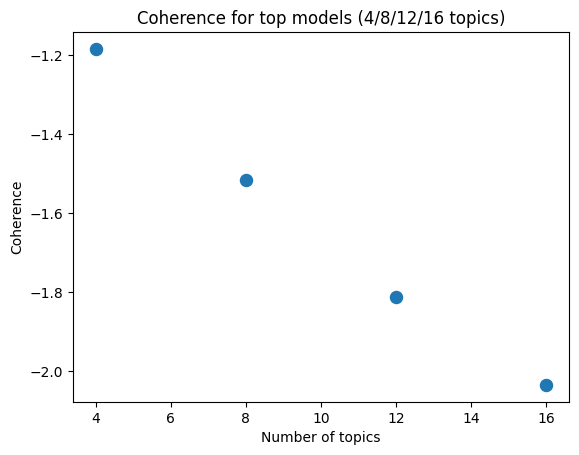

In [304]:
matplotlib.pyplot.scatter(list(best_coherence_lsi.keys()),list(best_coherence_lsi.values()), marker='.', s=300)
matplotlib.pyplot.xlabel("Number of topics")
matplotlib.pyplot.ylabel("Coherence")
matplotlib.pyplot.title("Coherence for top models (4/8/12/16 topics)")

>Когерентность падает с ростом числа заголовков

In [268]:
parameters_4 = best_parameters_lsi[4]
parameters_8 = best_parameters_lsi[8]
parameters_12 = best_parameters_lsi[4]
parameters_16 = best_parameters_lsi[8]

lsi_model_4 = LsiModel(common_corpus, num_topics=4, id2word=common_dictionary, chunksize=parameters_4[0],
                              decay=parameters_4[1], onepass=parameters_4[2], power_iters=parameters_4[3], extra_samples=parameters_4[4])
lsi_model_8 = LsiModel(common_corpus, num_topics=8, id2word=common_dictionary, chunksize=parameters_8[0],
                              decay=parameters_8[1], onepass=parameters_8[2], power_iters=parameters_8[3], extra_samples=parameters_8[4])
lsi_model_12 = LsiModel(common_corpus, num_topics=12, id2word=common_dictionary, chunksize=parameters_12[0],
                              decay=parameters_12[1], onepass=parameters_12[2], power_iters=parameters_12[3], extra_samples=parameters_12[4])
lsi_model_16 = LsiModel(common_corpus, num_topics=16, id2word=common_dictionary, chunksize=parameters_16[0],
                              decay=parameters_16[1], onepass=parameters_16[2], power_iters=parameters_16[3], extra_samples=parameters_16[4])

LSI topics (4)

In [269]:
for topic in lsi_model_4.show_topics():
    print(topic)

(0, '0.278*"рубль" + 0.242*"человек" + 0.207*"свой" + 0.145*"говорить" + 0.144*"время" + 0.138*"цена" + 0.133*"ребёнок" + 0.132*"новый" + 0.128*"стать" + 0.127*"россия"')
(1, '-0.627*"рубль" + 0.238*"человек" + -0.225*"цена" + -0.179*"миллион" + 0.156*"свой" + -0.124*"тысяча" + -0.120*"валюта" + -0.120*"доллар" + 0.113*"очень" + 0.108*"говорить"')
(2, '0.420*"ребёнок" + 0.315*"пособие" + -0.292*"цена" + 0.257*"семья" + 0.239*"выплата" + 0.203*"доход" + 0.173*"рубль" + 0.145*"прожиточный" + 0.145*"минимум" + 0.115*"родитель"')
(3, '-0.257*"рубль" + 0.216*"банк" + -0.184*"миллион" + 0.170*"человек" + -0.166*"новгород" + -0.156*"нижний" + 0.151*"валюта" + -0.137*"город" + 0.130*"доллар" + 0.124*"говорить"')


>Выявлены темы Общество и Экономика

LSI topics (8)

In [270]:
for topic in lsi_model_8.show_topics():
    print(topic)

(0, '0.278*"рубль" + 0.242*"человек" + 0.207*"свой" + 0.145*"говорить" + 0.144*"время" + 0.138*"цена" + 0.133*"ребёнок" + 0.132*"новый" + 0.128*"стать" + 0.127*"россия"')
(1, '-0.627*"рубль" + 0.238*"человек" + -0.225*"цена" + -0.179*"миллион" + 0.156*"свой" + -0.124*"тысяча" + -0.120*"валюта" + -0.120*"доллар" + 0.113*"очень" + 0.108*"говорить"')
(2, '0.420*"ребёнок" + 0.315*"пособие" + -0.292*"цена" + 0.257*"семья" + 0.239*"выплата" + 0.203*"доход" + 0.173*"рубль" + 0.145*"прожиточный" + 0.145*"минимум" + 0.115*"родитель"')
(3, '0.257*"рубль" + -0.216*"банк" + 0.184*"миллион" + -0.170*"человек" + 0.166*"новгород" + 0.156*"нижний" + -0.151*"валюта" + 0.137*"город" + -0.130*"доллар" + -0.124*"говорить"')
(4, '-0.297*"автомобиль" + -0.257*"машина" + 0.219*"цена" + -0.213*"миллион" + -0.184*"тысяча" + 0.165*"валюта" + -0.164*"водитель" + 0.157*"доллар" + 0.152*"пособие" + 0.148*"ребёнок"')
(5, '0.420*"рубль" + -0.259*"автомобиль" + 0.249*"человек" + -0.190*"машина" + -0.179*"пособие" + 0

>Добавилась тема Город

LSI topics (12)

In [271]:
for topic in lsi_model_12.show_topics():
    print(topic)

(0, '0.278*"рубль" + 0.242*"человек" + 0.207*"свой" + 0.145*"говорить" + 0.144*"время" + 0.138*"цена" + 0.133*"ребёнок" + 0.132*"новый" + 0.128*"стать" + 0.127*"россия"')
(1, '-0.627*"рубль" + 0.238*"человек" + -0.225*"цена" + -0.179*"миллион" + 0.156*"свой" + -0.124*"тысяча" + -0.120*"валюта" + -0.120*"доллар" + 0.113*"очень" + 0.108*"говорить"')
(2, '-0.420*"ребёнок" + -0.315*"пособие" + 0.292*"цена" + -0.257*"семья" + -0.239*"выплата" + -0.203*"доход" + -0.173*"рубль" + -0.145*"прожиточный" + -0.145*"минимум" + -0.115*"родитель"')
(3, '0.257*"рубль" + -0.216*"банк" + 0.184*"миллион" + -0.170*"человек" + 0.166*"новгород" + 0.156*"нижний" + -0.151*"валюта" + 0.137*"город" + -0.130*"доллар" + -0.124*"говорить"')
(4, '0.297*"автомобиль" + 0.257*"машина" + -0.219*"цена" + 0.213*"миллион" + 0.184*"тысяча" + -0.165*"валюта" + 0.164*"водитель" + -0.157*"доллар" + -0.152*"пособие" + -0.148*"ребёнок"')
(5, '-0.420*"рубль" + 0.259*"автомобиль" + -0.249*"человек" + 0.190*"машина" + 0.179*"пособ

>Добавилась тема Медицина/Здоровье

LSI topics (16)

In [272]:
for topic in lsi_model_16.show_topics():
    print(topic)

(0, '0.278*"рубль" + 0.242*"человек" + 0.207*"свой" + 0.145*"говорить" + 0.144*"время" + 0.138*"цена" + 0.133*"ребёнок" + 0.132*"новый" + 0.128*"стать" + 0.127*"россия"')
(1, '-0.627*"рубль" + 0.238*"человек" + -0.225*"цена" + -0.179*"миллион" + 0.156*"свой" + -0.124*"тысяча" + -0.120*"валюта" + -0.120*"доллар" + 0.113*"очень" + 0.108*"говорить"')
(2, '-0.420*"ребёнок" + -0.315*"пособие" + 0.292*"цена" + -0.257*"семья" + -0.239*"выплата" + -0.203*"доход" + -0.173*"рубль" + -0.145*"прожиточный" + -0.145*"минимум" + -0.115*"родитель"')
(3, '0.257*"рубль" + -0.216*"банк" + 0.184*"миллион" + -0.170*"человек" + 0.166*"новгород" + 0.156*"нижний" + -0.151*"валюта" + 0.137*"город" + -0.130*"доллар" + -0.124*"говорить"')
(4, '0.297*"автомобиль" + 0.257*"машина" + -0.219*"цена" + 0.213*"миллион" + 0.184*"тысяча" + -0.165*"валюта" + 0.164*"водитель" + -0.157*"доллар" + -0.152*"пособие" + -0.148*"ребёнок"')
(5, '-0.420*"рубль" + 0.259*"автомобиль" + -0.249*"человек" + 0.190*"машина" + 0.179*"пособ

**Non-Negative Matrix factorization**

In [295]:
from gensim.models.nmf import Nmf

In [301]:
num_of_categories_t = [4, 8, 12, 16]
chunksize_t = [1000, 2000]
passes_t = [1, 5]
kappa_t = [0.5, 1.0]
minimum_probability_t = [0.01, 0.05]
best_parameters_nmf = {num_of_categories_: [] for num_of_categories_ in num_of_categories_t}
best_coherence_nmf = {num_of_categories_: -100 for num_of_categories_ in num_of_categories_t}

for num_of_categories_ in num_of_categories_t:
    print("num_of_topics = " + str(num_of_categories_))
    best_nmf_model = Nmf(common_corpus, num_topics=num_of_categories_, id2word=common_dictionary, chunksize=chunksize_t[0],
                              passes=passes_t[0], kappa=kappa_t[0], minimum_probability=minimum_probability_t[0])
    coherence_model_nmf = CoherenceModel(model=best_nmf_model, corpus=common_corpus, dictionary=common_dictionary, coherence='u_mass')
    max_coherence = coherence_model_nmf.get_coherence()
    best_parameters_nmf[num_of_categories_] = [chunksize_t[0], passes_t[0], kappa_t[0], minimum_probability_t[0]]
    for chunksize_ in chunksize_t:
        for passes_ in passes_t:
            for kappa_ in kappa_t:
                for minimum_probability_ in minimum_probability_t:
                    print("chunksize = " + str(chunksize_) + " passes = " + str(passes_) + " kappa = " + str(kappa_) + " minimum probability = " + str(minimum_probability_))
                    nmf_model = Nmf(common_corpus, num_topics=num_of_categories_, id2word=common_dictionary, chunksize=chunksize_,
                                    passes=passes_, kappa=kappa_, minimum_probability=minimum_probability_)
                    coherence_model_nmf = CoherenceModel(model=nmf_model, corpus=common_corpus, dictionary=common_dictionary, coherence='u_mass')
                    if (coherence_model_nmf.get_coherence() > max_coherence):
                        best_nmf_model = nmf_model
                        max_coherence = coherence_model_nmf.get_coherence()
                        best_parameters_nmf[num_of_categories_] = [chunksize_, passes_, kappa_, minimum_probability_]
    best_coherence_nmf[num_of_categories_] = max_coherence

num_of_topics = 4
chunksize = 1000 passes = 1 kappa = 0.5 minimum probability = 0.01
chunksize = 1000 passes = 1 kappa = 0.5 minimum probability = 0.05
chunksize = 1000 passes = 1 kappa = 1.0 minimum probability = 0.01
chunksize = 1000 passes = 1 kappa = 1.0 minimum probability = 0.05
chunksize = 1000 passes = 5 kappa = 0.5 minimum probability = 0.01
chunksize = 1000 passes = 5 kappa = 0.5 minimum probability = 0.05
chunksize = 1000 passes = 5 kappa = 1.0 minimum probability = 0.01
chunksize = 1000 passes = 5 kappa = 1.0 minimum probability = 0.05
chunksize = 2000 passes = 1 kappa = 0.5 minimum probability = 0.01
chunksize = 2000 passes = 1 kappa = 0.5 minimum probability = 0.05
chunksize = 2000 passes = 1 kappa = 1.0 minimum probability = 0.01
chunksize = 2000 passes = 1 kappa = 1.0 minimum probability = 0.05
chunksize = 2000 passes = 5 kappa = 0.5 minimum probability = 0.01
chunksize = 2000 passes = 5 kappa = 0.5 minimum probability = 0.05
chunksize = 2000 passes = 5 kappa = 1.0 mini

Text(0.5, 1.0, 'Coherence for top models (4/8/12/16 topics)')

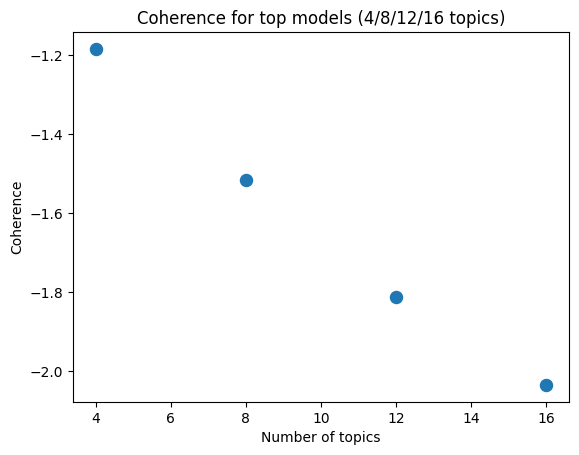

In [303]:
matplotlib.pyplot.scatter(list(best_coherence_nmf.keys()),list(best_coherence_lsi.values()), marker='.', s=300)
matplotlib.pyplot.xlabel("Number of topics")
matplotlib.pyplot.ylabel("Coherence")
matplotlib.pyplot.title("Coherence for top models (4/8/12/16 topics)")

>Как и у предыдущех моделей, когерентность ухудшается с ростом числа тем.

In [305]:
parameters_4 = best_parameters_nmf[4]
parameters_8 = best_parameters_nmf[8]
parameters_12 = best_parameters_nmf[4]
parameters_16 = best_parameters_nmf[8]

nmf_model_4 = Nmf(common_corpus, num_topics=4, id2word=common_dictionary, chunksize=parameters_4[0],
                                    passes=parameters_4[1], kappa=parameters_4[2], minimum_probability=parameters_4[3])
nmf_model_8 = Nmf(common_corpus, num_topics=8, id2word=common_dictionary, chunksize=parameters_8[0],
                                    passes=parameters_8[1], kappa=parameters_8[2], minimum_probability=parameters_8[3])
nmf_model_12 = Nmf(common_corpus, num_topics=12, id2word=common_dictionary, chunksize=parameters_12[0],
                                    passes=parameters_12[1], kappa=parameters_12[2], minimum_probability=parameters_12[3])
nmf_model_16 = Nmf(common_corpus, num_topics=16, id2word=common_dictionary, chunksize=parameters_16[0],
                                    passes=parameters_16[1], kappa=parameters_16[2], minimum_probability=parameters_16[3])

NMF topics (4)

In [306]:
for topic in nmf_model_4.show_topics():
    print(topic)

(0, '0.012*"человек" + 0.007*"свой" + 0.006*"говорить" + 0.005*"очень" + 0.004*"время" + 0.004*"стать" + 0.003*"жизнь" + 0.003*"большой" + 0.003*"день" + 0.003*"просто"')
(1, '0.010*"рубль" + 0.007*"свой" + 0.006*"миллион" + 0.006*"нижний" + 0.006*"новгород" + 0.005*"город" + 0.004*"новый" + 0.004*"нижегородский" + 0.004*"театр" + 0.004*"программа"')
(2, '0.020*"рубль" + 0.012*"цена" + 0.007*"россия" + 0.007*"тысяча" + 0.006*"автомобиль" + 0.006*"банк" + 0.006*"рынок" + 0.005*"доллар" + 0.005*"валюта" + 0.005*"курс"')
(3, '0.035*"ребёнок" + 0.021*"пособие" + 0.020*"семья" + 0.016*"выплата" + 0.014*"доход" + 0.010*"минимум" + 0.009*"родитель" + 0.009*"прожиточный" + 0.007*"получить" + 0.006*"сумма"')


>Выявлены темы Общество, Экономика и Город

NMF topics (8)

In [307]:
for topic in nmf_model_8.show_topics():
    print(topic)

(0, '0.033*"ребёнок" + 0.019*"семья" + 0.016*"пособие" + 0.013*"выплата" + 0.009*"доход" + 0.009*"родитель" + 0.008*"день" + 0.007*"минимум" + 0.006*"прожиточный" + 0.006*"получить"')
(1, '0.016*"свой" + 0.010*"человек" + 0.008*"жизнь" + 0.006*"театр" + 0.005*"спектакль" + 0.005*"артист" + 0.004*"роль" + 0.004*"актёр" + 0.004*"фильм" + 0.004*"сколько"')
(2, '0.012*"говорить" + 0.010*"хороший" + 0.010*"очень" + 0.009*"россия" + 0.007*"знать" + 0.006*"банк" + 0.006*"фильм" + 0.006*"деньга" + 0.005*"стать" + 0.005*"российский"')
(3, '0.024*"человек" + 0.009*"говорить" + 0.007*"врач" + 0.007*"случай" + 0.005*"нужно" + 0.005*"заболевание" + 0.005*"пациент" + 0.004*"очень" + 0.004*"проблема" + 0.004*"болезнь"')
(4, '0.009*"новый" + 0.007*"работа" + 0.007*"свой" + 0.007*"город" + 0.006*"дом" + 0.006*"нижний" + 0.006*"новгород" + 0.005*"стать" + 0.005*"проект" + 0.005*"время"')
(5, '0.066*"рубль" + 0.026*"миллион" + 0.014*"тысяча" + 0.012*"миллиард" + 0.006*"ребёнок" + 0.006*"сумма" + 0.006*"б

>Добавились темы Злоровье и Культура

NMF topics (12)

In [308]:
for topic in nmf_model_12.show_topics():
    print(topic)

(1, '0.009*"игра" + 0.008*"россия" + 0.008*"свой" + 0.008*"хороший" + 0.007*"фильм" + 0.006*"страна" + 0.006*"стать" + 0.005*"первый" + 0.005*"российский" + 0.004*"мир"')
(8, '0.016*"автомобиль" + 0.013*"машина" + 0.011*"новый" + 0.007*"модель" + 0.006*"россия" + 0.006*"тысяча" + 0.006*"водитель" + 0.005*"например" + 0.004*"компания" + 0.004*"версия"')
(6, '0.009*"театр" + 0.009*"сколько" + 0.008*"руб" + 0.008*"концерт" + 0.007*"спектакль" + 0.007*"ул" + 0.007*"новгород" + 0.007*"нижний" + 0.007*"цена" + 0.006*"фестиваль"')
(10, '0.013*"город" + 0.012*"улица" + 0.009*"область" + 0.008*"место" + 0.008*"нижний" + 0.008*"новгород" + 0.007*"тюмень" + 0.007*"наш" + 0.007*"дом" + 0.006*"дорога"')
(2, '0.012*"банк" + 0.009*"работа" + 0.007*"компания" + 0.007*"работать" + 0.006*"говорить" + 0.005*"кредит" + 0.005*"деньга" + 0.005*"время" + 0.004*"ставка" + 0.004*"день"')
(0, '0.020*"очень" + 0.015*"говорить" + 0.011*"знать" + 0.009*"человек" + 0.008*"сказать" + 0.007*"просто" + 0.007*"хотеть" 

>Добавилась тема Кино

NMF topics (16)

In [309]:
for topic in nmf_model_16.show_topics():
    print(topic)

(4, '0.013*"фильм" + 0.012*"стать" + 0.007*"актёр" + 0.007*"роль" + 0.004*"актриса" + 0.004*"съёмка" + 0.004*"место" + 0.003*"кино" + 0.003*"жизнь" + 0.003*"режиссёр"')
(9, '0.019*"россия" + 0.015*"новый" + 0.012*"страна" + 0.009*"российский" + 0.008*"компания" + 0.007*"рынок" + 0.005*"доллар" + 0.005*"проект" + 0.004*"стать" + 0.004*"наш"')
(2, '0.022*"свой" + 0.011*"жизнь" + 0.007*"время" + 0.006*"история" + 0.006*"работа" + 0.005*"очень" + 0.005*"наш" + 0.005*"книга" + 0.005*"хороший" + 0.004*"друг"')
(1, '0.010*"концерт" + 0.009*"песня" + 0.009*"группа" + 0.009*"новый" + 0.008*"программа" + 0.007*"театр" + 0.006*"новгород" + 0.006*"сколько" + 0.006*"нижний" + 0.005*"стать"')
(6, '0.012*"город" + 0.011*"дом" + 0.011*"нижний" + 0.010*"улица" + 0.009*"новгород" + 0.008*"область" + 0.008*"нижегородский" + 0.007*"наш" + 0.007*"работа" + 0.005*"район"')
(3, '0.015*"ребёнок" + 0.010*"человек" + 0.010*"заболевание" + 0.008*"случай" + 0.008*"пациент" + 0.008*"служба" + 0.007*"лечение" + 0.0

**Coherence for LDA, LSI and NMF models**

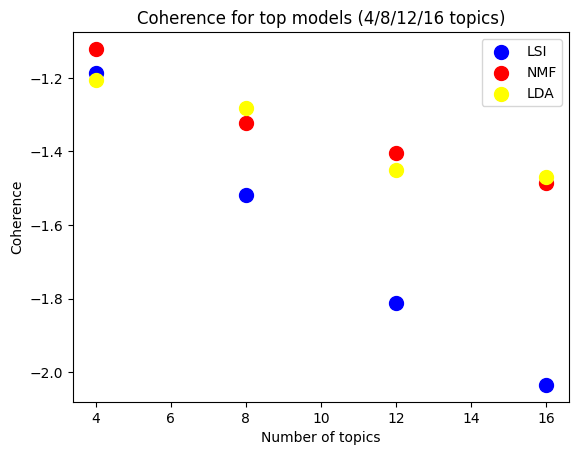

In [328]:
matplotlib.pyplot.scatter(list(best_coherence_lsi.keys()),list(best_coherence_lsi.values()), marker='.', s=400, color='b', label="LSI")
matplotlib.pyplot.xlabel("Number of topics")
matplotlib.pyplot.ylabel("Coherence")
matplotlib.pyplot.title("Coherence for top models (4/8/12/16 topics)")
#matplotlib.pyplot.hold()
matplotlib.pyplot.scatter(list(best_coherence_nmf.keys()),list(best_coherence_nmf.values()), marker='.', s=400, color='r', label="NMF")
matplotlib.pyplot.scatter(list(best_coherence_lda.keys()),list(best_coherence_lda.values()), marker='.', s=400, color='yellow', label="LDA")
matplotlib.pyplot.legend()
matplotlib.pyplot.show()

>Значительно хуже себя показывает модель LSI. Модели LDA и NMF похожи по этой характеристике.

>По количеству найденных тем, которые присутствуют в исходном датасете лидирует LDA